### RNAseq analysis using R package Seurat
* We will perform the guided analysis found at https://satijalab.org/seurat/get_started.html
* Using rpy2, we demonstrate how to call R from Python
* rpy2 also allows us to utilize R packages from within Python
* This provides the added benefit of Python utilities and data handling efficiency

In [1]:
from rpy2.robjects import r

In [2]:
r('library(Matrix)')

'Matrix','tools','RevoUtils','stats',...,'utils','datasets','methods','base'


In [3]:
import warnings
warnings.filterwarnings('ignore')
r('library(Seurat)')

'Seurat','cowplot','ggplot2','Matrix',...,'utils','datasets','methods','base'


In [4]:
r('library(dplyr)')

'dplyr','Seurat','cowplot','ggplot2',...,'utils','datasets','methods','base'


In [5]:
# load the PBMC dataset
r('pbmc.data <- Read10X(data.dir = "~/Downloads/filtered_gene_bc_matrices/hg19/")')

R object with classes: ('dgTMatrix',) mapped to:
<RS4 - Python:0x7fa7449845c8 / R:0x559356b793f8>

In [6]:
# Examine the memory savings between regular and sparse matrices
r('dense.size <- object.size(x = as.matrix(x = pbmc.data))')

709264728.000000


In [7]:
r('sparse.size <- object.size(x = pbmc.data)')

38715120.000000


In [8]:
r('dense.size/sparse.size')

18.320096


In [9]:
# Initialize the Seurat object with the raw (non-normalized data).  Keep all
# genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at
# least 200 detected genes
r('pbmc <- CreateSeuratObject(raw.data = pbmc.data, min.cells = 3, min.genes = 200, project = "10X_PBMC")')

R object with classes: ('seurat',) mapped to:
<RS4 - Python:0x7fa72cbda7c8 / R:0x559358a13d70>

In [10]:
import IPython
print(IPython.sys_info())
import matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

{'commit_hash': 'dd83a2163',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/home/frank/anaconda3/lib/python3.5/site-packages/IPython',
 'ipython_version': '6.5.0',
 'os_name': 'posix',
 'platform': 'Linux-4.15.0-33-generic-x86_64-with-debian-buster-sid',
 'sys_executable': '/home/frank/anaconda3/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.5.5 |Anaconda, Inc.| (default, May 13 2018, 21:12:35) \n'
                '[GCC 7.2.0]'}


In [13]:
%load_ext rmagic
%load_ext rpy2.ipython

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


## Quality control and selecting cells for further analysis

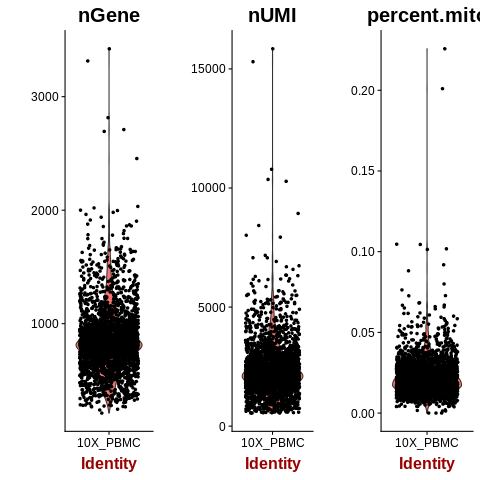

In [22]:
# The number of genes and UMIs (nGene and nUMI) are automatically calculated
# for every object by Seurat.  For non-UMI data, nUMI represents the sum of
# the non-normalized values within a cell We calculate the percentage of
# mitochondrial genes here and store it in percent.mito using AddMetaData.
# We use object@raw.data since this represents non-transformed and
# non-log-normalized counts The % of UMI mapping to MT-genes is a common
# scRNA-seq QC metric.
r('mito.genes <- grep(pattern = "^MT-", x = rownames(x = pbmc@data), value = TRUE)')
r('percent.mito <- Matrix::colSums(pbmc@raw.data[mito.genes, ])/Matrix::colSums(pbmc@raw.data)')

# AddMetaData adds columns to object@meta.data, and is a great place to
# stash QC stats
r('pbmc <- AddMetaData(object = pbmc, metadata = percent.mito, col.name = "percent.mito")')



try:
    %R print(VlnPlot(object = pbmc, features.plot = c("nGene", "nUMI", "percent.mito"), nCol = 3))
except Exception:
    pass


NULL


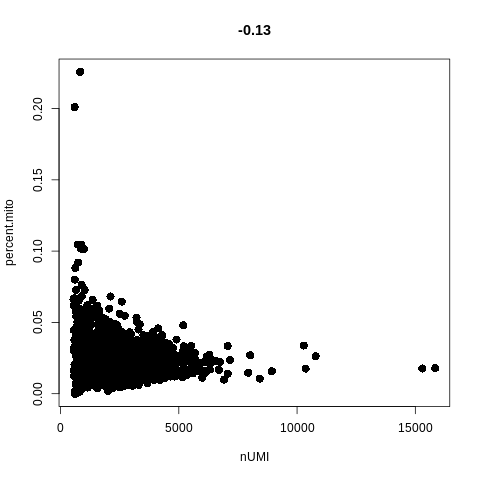

NULL


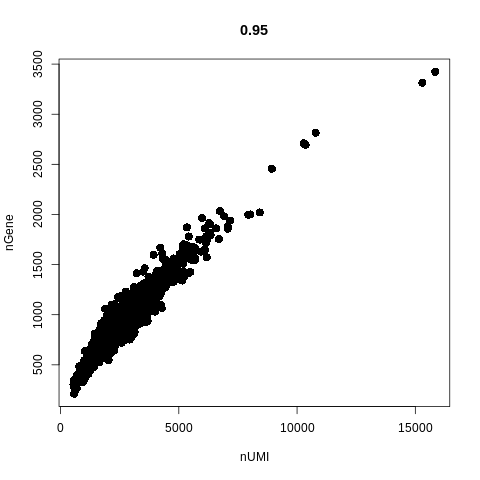

In [25]:
# GenePlot is typically used to visualize gene-gene relationships, but can
# be used for anything calculated by the object, i.e. columns in
# object@meta.data, PC scores etc.  Since there is a rare subset of cells
# with an outlier level of high mitochondrial percentage and also low UMI
# content, we filter these as well
try:
    %R print(GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "percent.mito"))
    %R print(GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "nGene"))
except Exception:
    pass


In [26]:
# We filter out cells that have unique gene counts over 2,500 or less than
# 200 Note that low.thresholds and high.thresholds are used to define a
# 'gate'.  -Inf and Inf should be used if you don't want a lower or upper threshold.
# We filter out cells that have unique gene counts over 2,500 or less than
# 200 Note that low.thresholds and high.thresholds are used to define a
# 'gate'.  -Inf and Inf should be used if you don't want a lower or upper threshold.

r('pbmc <- FilterCells(object = pbmc, subset.names = c("nGene", "percent.mito"),     low.thresholds = c(200, -Inf), high.thresholds = c(2500, 0.05))')

R object with classes: ('seurat',) mapped to:
<RS4 - Python:0x7fa6ec26a8c8 / R:0x55935e5178e8>

## Normalizing the data

In [27]:
r('pbmc <- NormalizeData(object = pbmc, normalization.method = "LogNormalize", scale.factor = 10000)')

R object with classes: ('seurat',) mapped to:
<RS4 - Python:0x7fa6ec26aec8 / R:0x55935e2dece8>

## Detection of variable genes across the single cells

An object of class seurat in project 10X_PBMC 
 13714 genes across 2638 samples.


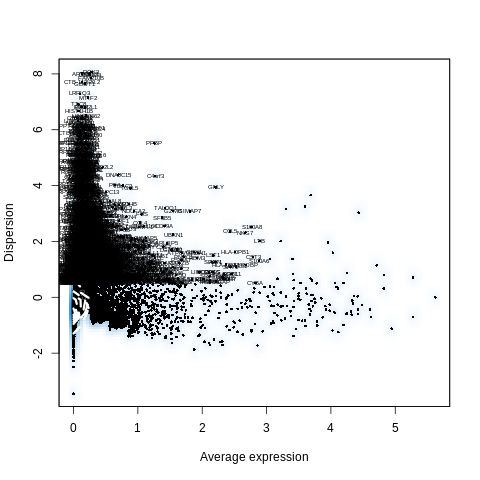

In [28]:
try:
    %R print(pbmc <- FindVariableGenes(object = pbmc, mean.function = ExpMean, dispersion.function = LogVMR,x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5))
except Exception:
    pass

In [29]:
r('length(x = pbmc@var.genes)')

"1,838"


## Scaling the data and removing unwanted sources of variation

In [31]:
r('pbmc <- ScaleData(object = pbmc, vars.to.regress = c("nUMI", "percent.mito"))')

R object with classes: ('seurat',) mapped to:
<RS4 - Python:0x7fa6ec2318c8 / R:0x559373da4a18>

## Perform linear dimension reduction

In [34]:
try:
    %R print(pbmc <- RunPCA(object = pbmc, pc.genes = pbmc@var.genes, do.print = TRUE, pcs.print = 1:5, genes.print = 5))
except Exception:
    pass


Time Elapsed:  28.7451610565186 secs[1] "PC1"
[1] "CST3"   "TYROBP" "FCN1"   "LST1"   "AIF1"  
[1] ""
[1] "PTPRCAP" "IL32"    "LTB"     "CD2"     "CTSW"   
[1] ""
[1] ""
[1] "PC2"
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] ""
[1] ""
[1] "PC3"
[1] "CYBA"     "HLA-DPA1" "HLA-DPB1" "HLA-DRB1" "CD37"    
[1] ""
[1] "PF4"   "PPBP"  "SDPR"  "SPARC" "GNG11"
[1] ""
[1] ""
[1] "PC4"
[1] "CD79A"    "HLA-DQA1" "CD79B"    "MS4A1"    "HLA-DQB1"
[1] ""
[1] "IL32"   "GIMAP7" "AQP3"   "FYB"    "MAL"   
[1] ""
[1] ""
[1] "PC5"
[1] "FCGR3A"        "CTD-2006K23.1" "IFITM3"        "ABI3"         
[5] "CEBPB"        
[1] ""
[1] "FCER1A"  "LGALS2"  "MS4A6A"  "S100A8"  "CLEC10A"
[1] ""
[1] ""
[1] "PC1"
[1] "CST3"   "TYROBP" "FCN1"   "LST1"   "AIF1"  
[1] ""
[1] "PTPRCAP" "IL32"    "LTB"     "CD2"     "CTSW"   
[1] ""
[1] ""
[1] "PC2"
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] "

$mfrow
[1] 1 2



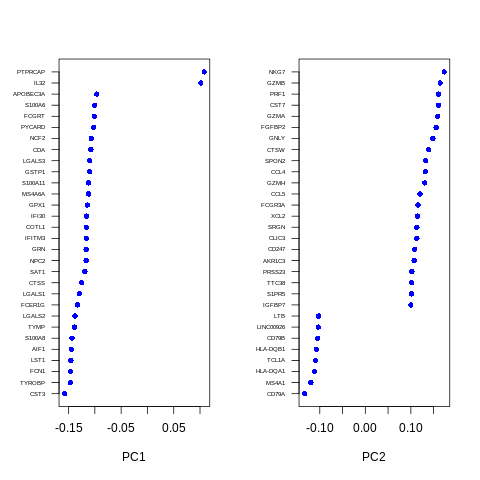

In [35]:
try:
    %R print(VizPCA(object = pbmc, pcs.use = 1:2))
except Exception:
    pass

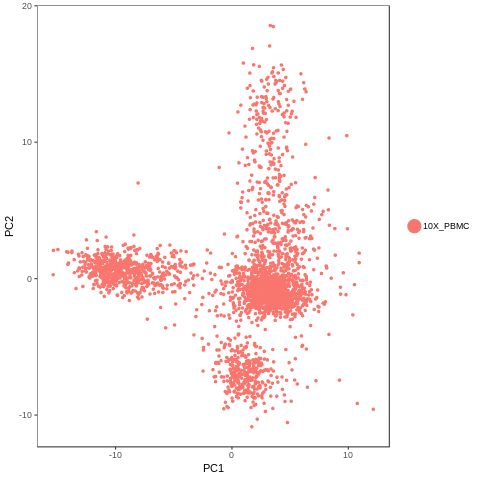

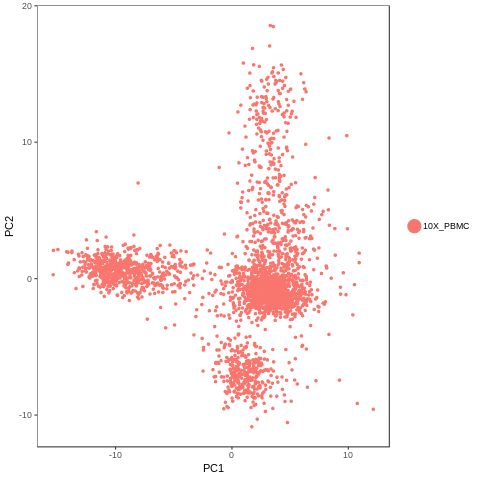

In [36]:
try:
    %R print(PCAPlot(object = pbmc, dim.1 = 1, dim.2 = 2))
except Exception:
    pass

In [37]:
# ProjectPCA scores each gene in the dataset (including genes not included
# in the PCA) based on their correlation with the calculated components.
# Though we don't use this further here, it can be used to identify markers
# that are strongly correlated with cellular heterogeneity, but may not have
# passed through variable gene selection.  The results of the projected PCA
# can be explored by setting use.full=T in the functions above
r('pbmc <- ProjectPCA(object = pbmc, do.print = FALSE)')

R object with classes: ('seurat',) mapped to:
<RS4 - Python:0x7fa6ec236148 / R:0x559359b95778>

$mfrow
[1] 1 1



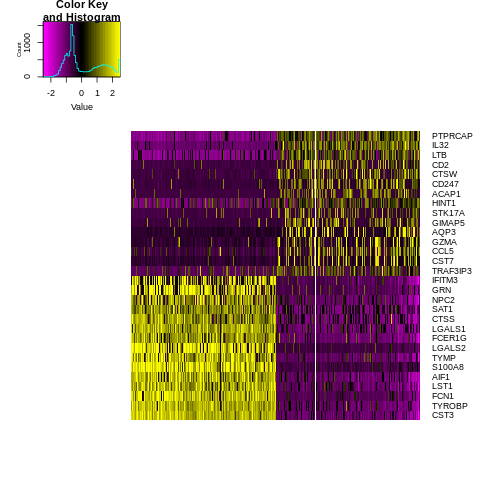

In [38]:
try:
    %R print(PCHeatmap(object = pbmc, pc.use = 1, cells.use = 500, do.balanced = TRUE, label.columns = FALSE))
except Exception:
    pass

$mfrow
[1] 4 3



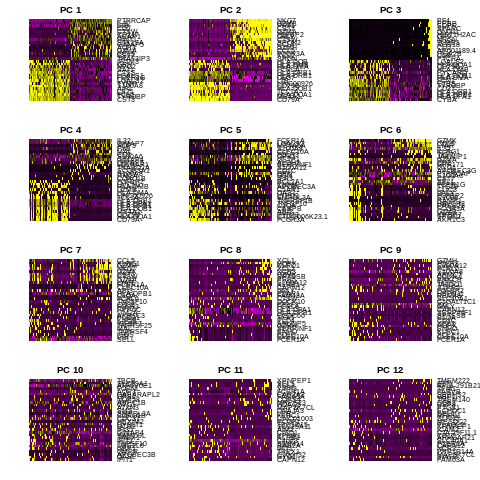

In [39]:
try:
    %R print(PCHeatmap(object = pbmc, pc.use = 1:12, cells.use = 500, do.balanced = TRUE, label.columns = FALSE, use.full = FALSE))
except Exception:
    pass

## Determine statistically significant principal components

In [42]:
# NOTE: This process can take a long time for big datasets, comment out for
# expediency.  More approximate techniques such as those implemented in
# PCElbowPlot() can be used to reduce computation time

try:
    %R pbmc <- JackStraw(object = pbmc, num.replicate = 100, display.progress = FALSE)
except Exception:
    pass

An object of class seurat in project 10X_PBMC 
 13714 genes across 2638 samples.


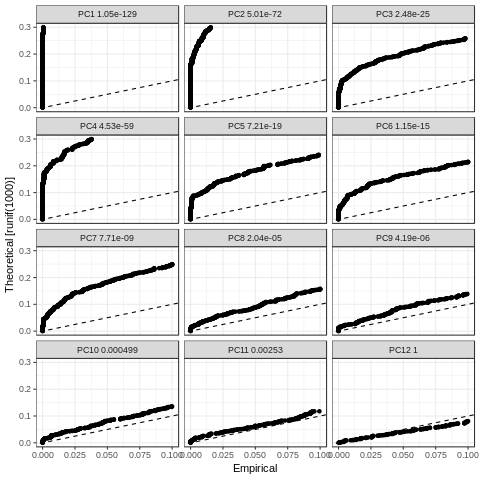

In [43]:
try:
    %R print(JackStrawPlot(object = pbmc, PCs = 1:12))
except Exception:
    pass

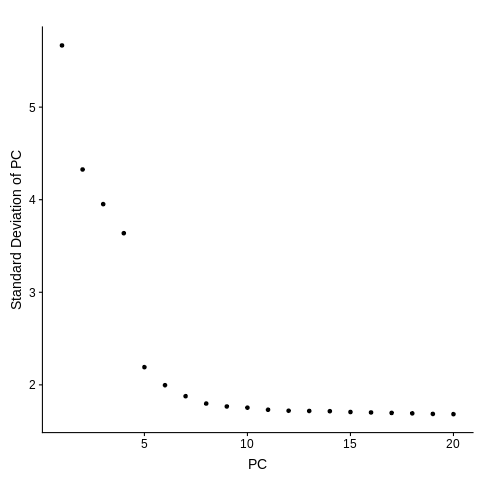

In [44]:
try:
    %R print(PCElbowPlot(object = pbmc))
except Exception:
    pass



## Cluster the cells

In [45]:
# save.SNN = T saves the SNN so that the clustering algorithm can be rerun
# using the same graph but with a different resolution value (see docs for
# full details)
r('pbmc <- FindClusters(object = pbmc, reduction.type = "pca", dims.use = 1:10, resolution = 0.6, print.output = 0, save.SNN = TRUE)')

R object with classes: ('seurat',) mapped to:
<RS4 - Python:0x7fa6ecaefc88 / R:0x55938c757b00>

In [46]:
try:
    %R print(PrintFindClustersParams(object = pbmc))
except Exception:
    pass

Parameters used in latest FindClusters calculation run on: 2018-09-02 15:06:25
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          prune.SNN
     pca                 30                0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10

NULL


## Run nonlinear dimension reduction

In [47]:
r('pbmc <- RunTSNE(object = pbmc, dims.use = 1:10, do.fast = TRUE)')

R object with classes: ('seurat',) mapped to:
<RS4 - Python:0x7fa70aaacf08 / R:0x559382ed9580>

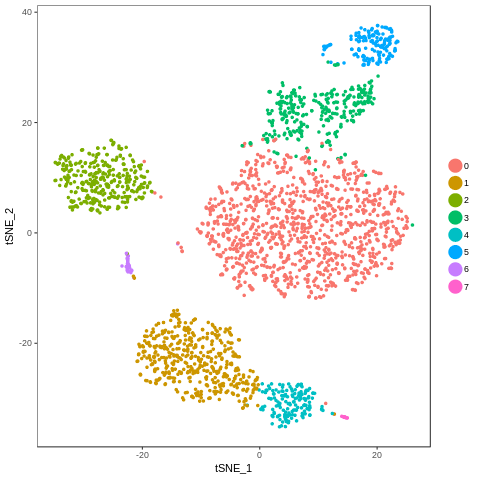

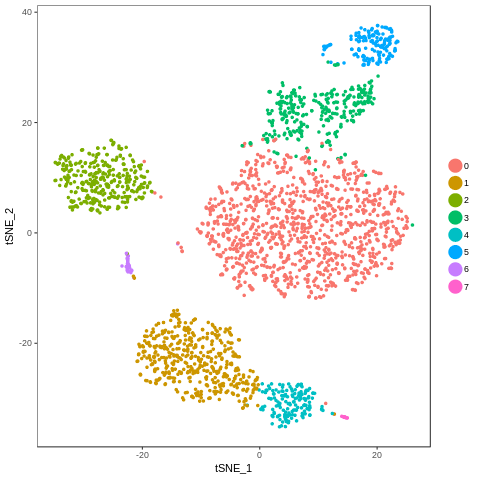

In [48]:
try:
    %R print(TSNEPlot(object = pbmc))
except Exception:
    pass

## Finding differentially expressed genes (cluster biomarkers)

In [49]:
# find all markers of cluster 1
try:
    %R cluster1.markers <- FindMarkers(object = pbmc, ident.1 = 1, min.pct = 0.25)
    %R print(x = head(x = cluster1.markers, n = 5))
except Exception:
    pass

   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 17s


              p_val avg_logFC pct.1 pct.2     p_val_adj
S100A9  0.00000e+00  3.830954 0.996 0.216  0.000000e+00
S100A8  0.00000e+00  3.786963 0.973 0.122  0.000000e+00
LGALS2  0.00000e+00  2.639056 0.908 0.060  0.000000e+00
FCN1    0.00000e+00  2.367232 0.954 0.151  0.000000e+00
CD14   5.05283e-289  1.947447 0.662 0.029 6.929451e-285


In [50]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
try:
    %R cluster5.markers <- FindMarkers(object = pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
    %R print(x = head(x = cluster5.markers, n = 5))
except Exception:
    pass

   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 11s


               p_val avg_logFC pct.1 pct.2     p_val_adj
GZMB   2.280513e-190  3.195731 0.955 0.084 3.127496e-186
IGFBP7 1.859718e-155  2.175973 0.542 0.010 2.550417e-151
GNLY   5.014639e-155  3.515681 0.961 0.143 6.877075e-151
FGFBP2 5.082837e-150  2.558487 0.852 0.086 6.970603e-146
SPON2  4.814899e-141  2.191047 0.716 0.053 6.603153e-137


In [51]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
try: 
    %R pbmc.markers <- FindAllMarkers(object = pbmc, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25)
    %R print(pbmc.markers %>% group_by(cluster) %>% top_n(2, avg_logFC))
except Exception:
    pass

   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 12s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 18s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 12s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 07s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 23s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 19s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 20s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 29s


# A tibble: 16 x 7
# Groups:   cluster [8]
       p_val avg_logFC pct.1 pct.2 p_val_adj cluster gene    
       <dbl>     <dbl> <dbl> <dbl>     <dbl> <fct>   <chr>   
 1 1.47e-234      1.15 0.924 0.482 2.01e-230 0       LDHB    
 2 3.09e-129      1.07 0.662 0.202 4.24e-125 0       IL7R    
 3 0.             3.83 0.996 0.216 0.        1       S100A9  
 4 0.             3.79 0.973 0.122 0.        1       S100A8  
 5 0.             2.98 0.936 0.042 0.        2       CD79A   
 6 1.06e-269      2.49 0.623 0.022 1.45e-265 2       TCL1A   
 7 8.03e-207      2.16 0.974 0.23  1.10e-202 3       CCL5    
 8 1.12e-181      2.11 0.588 0.05  1.53e-177 3       GZMK    
 9 1.04e-172      2.28 0.962 0.137 1.42e-168 4       FCGR3A  
10 7.13e-123      2.15 1     0.316 9.78e-119 4       LST1    
11 9.12e-265      3.33 0.955 0.068 1.25e-260 5       GZMB    
12 6.25e-192      3.76 0.961 0.131 8.57e-188 5       GNLY    
13 2.51e-238      2.73 0.844 0.011 3.44e-234 6       FCER1A  
14 7.04e- 21      1.97 1   

In [52]:
r('cluster1.markers <- FindMarkers(object = pbmc, ident.1 = 0, thresh.use = 0.25, test.use = "roc", only.pos = TRUE)')

myAUC,avg_diff,power,avg_logFC,pct.1,pct.2,p_val_adj
0.864000,1.148805,0.728000,1.148805,0.924000,0.482000,NA_real_
0.863000,0.592360,0.726000,0.592360,1.000000,0.989000,NA_real_
0.846000,0.630154,0.692000,0.630154,0.999000,0.967000,NA_real_
0.834000,0.555035,0.668000,0.555035,0.999000,0.989000,NA_real_
...,...,...,...,...,...,...
0.528000,0.251919,0.056000,0.251919,0.146000,0.091000,NA_real_
0.527000,0.250423,0.054000,0.250423,0.165000,0.110000,NA_real_


   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 02s


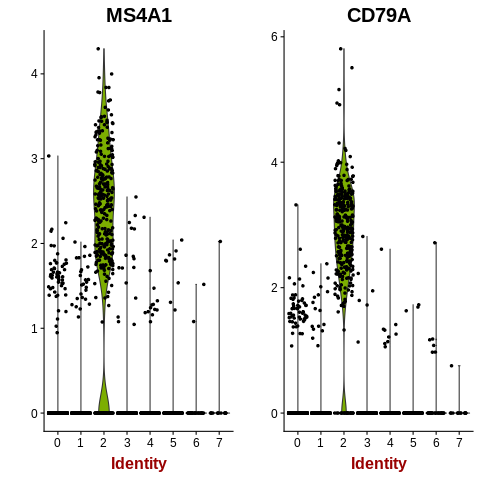

In [53]:
try:
    %R print(VlnPlot(object = pbmc, features.plot = c("MS4A1", "CD79A")))
except Exception:
    pass

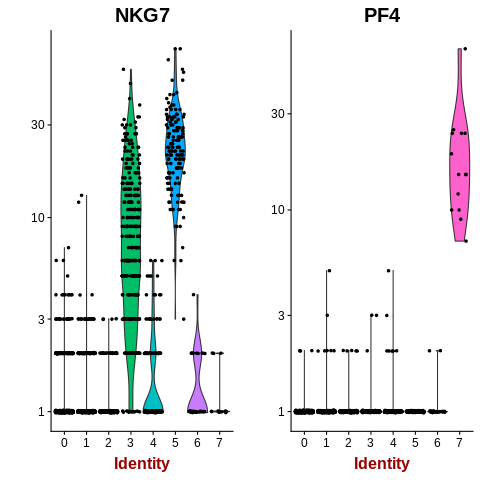

In [54]:
# you can plot raw UMI counts as well
try:
    %R print(VlnPlot(object = pbmc, features.plot = c("NKG7", "PF4"), use.raw = TRUE, y.log = TRUE))
except Exception:
    pass

NULL


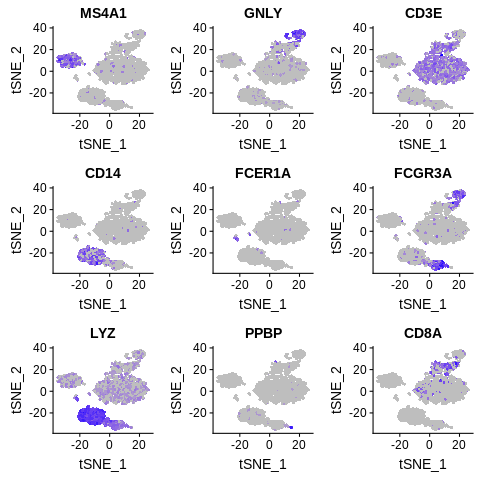

In [56]:
try:
    %R print(FeaturePlot(object = pbmc, features.plot = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"), cols.use = c("grey", "blue"), reduction.use = "tsne"))
except Exception:
    pass

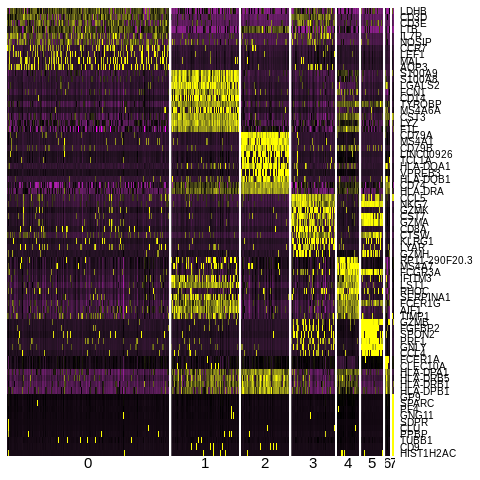

In [57]:
r('top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(10, avg_logFC)')
# setting slim.col.label to TRUE will print just the cluster IDS instead of # every cell name
try: 
    %R print(DoHeatmap(object = pbmc, genes.use = top10$gene, slim.col.label = TRUE, remove.key = TRUE))
except Exception:
    pass

## Assigning cell type identity to clusters

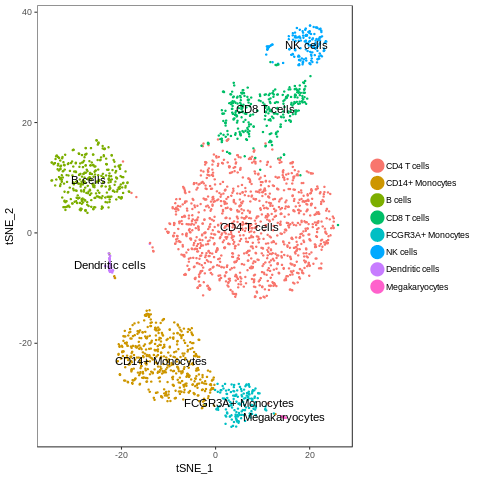

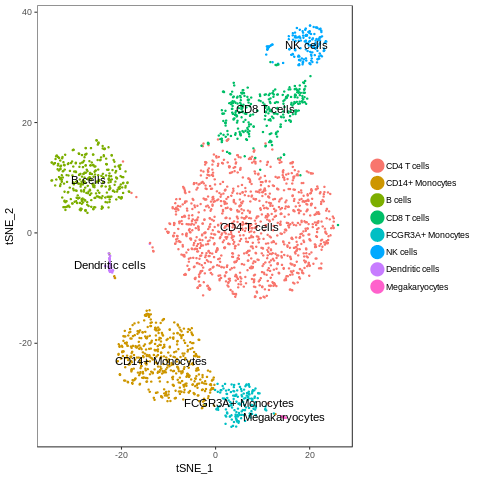

In [58]:
r('current.cluster.ids <- c(0, 1, 2, 3, 4, 5, 6, 7)')
r('new.cluster.ids <- c("CD4 T cells", "CD14+ Monocytes", "B cells", "CD8 T cells", "FCGR3A+ Monocytes", "NK cells", "Dendritic cells", "Megakaryocytes")')
r('pbmc@ident <- plyr::mapvalues(x = pbmc@ident, from = current.cluster.ids, to = new.cluster.ids)')
try:
    %R print(TSNEPlot(object = pbmc, do.label = TRUE, pt.size = 0.5))
except Exception:
    pass

## Further subdivisions within cell types

In [59]:
# First lets stash our identities for later
r('pbmc <- StashIdent(object = pbmc, save.name = "ClusterNames_0.6")')

# Note that if you set save.snn=T above, you don't need to recalculate the
# SNN, and can simply put: pbmc <- FindClusters(pbmc,resolution = 0.8)
r('pbmc <- FindClusters(object = pbmc, reduction.type = "pca", dims.use = 1:10, resolution = 0.8, print.output = FALSE)')

R object with classes: ('seurat',) mapped to:
<RS4 - Python:0x7fa70aac5c48 / R:0x55938ec53128>

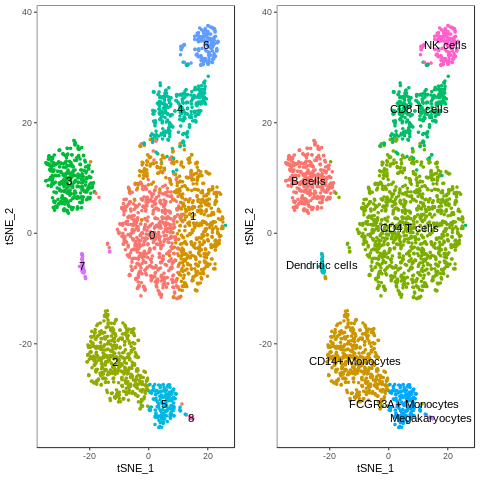

In [61]:
# Demonstration of how to plot two tSNE plots side by side, and how to color points based on different criteria
r('plot1 <- TSNEPlot(object = pbmc, do.return = TRUE, no.legend = TRUE, do.label = TRUE)')
r('plot2 <- TSNEPlot(object = pbmc, do.return = TRUE, group.by = "ClusterNames_0.6", no.legend = TRUE, do.label = TRUE)')
try:
    %R print(plot_grid(plot1, plot2))
except Exception:
    pass

   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 03s
NULL


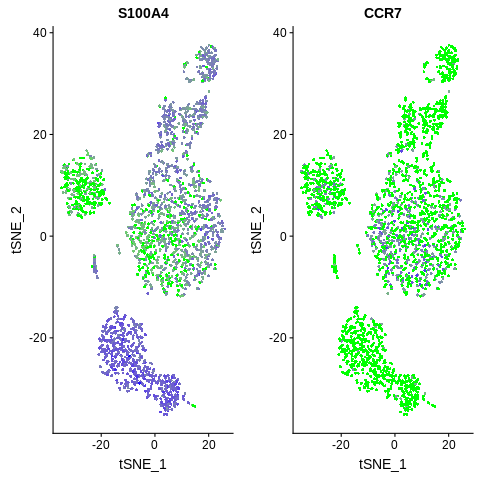

In [62]:
# Find discriminating markers
r('tcell.markers <- FindMarkers(object = pbmc, ident.1 = 0, ident.2 = 1)')

# Most of the markers tend to be expressed in C1 (i.e. S100A4). However, we
# can see that CCR7 is upregulated in C0, strongly indicating that we can
# differentiate memory from naive CD4 cells.  cols.use demarcates the color
# palette from low to high expression
try:
    %R print(FeaturePlot(object = pbmc, features.plot = c("S100A4", "CCR7"), cols.use = c("green", "blue")))
except Exception:
    pass